#Imports to be taken 

In [113]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import tensorflow as tf

#Visualizing the data

In [114]:
!unzip data.zip

Archive:  data.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of data.zip or
        data.zip.zip, and cannot find data.zip.ZIP, period.


Training images ( Image and its Label)

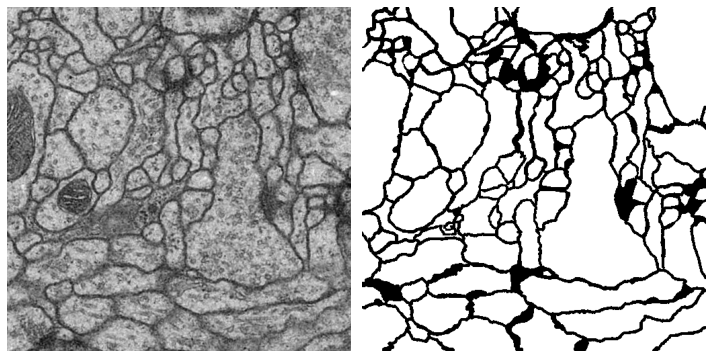

In [51]:
import cv2
fig = plt.figure(figsize=(10, 7))
num = np.random.randint(0,15)

fig.add_subplot(1,2, 1)
img = cv2.imread('/content/data/train/image/'+str(num)+'.png')
plt.imshow(img/255, cmap = "gray")
plt.axis("off")
plt.tight_layout()

fig.add_subplot(1,2, 2)
img = cv2.imread('/content/data/train/label/'+str(num)+'.png')
plt.imshow(img/255, cmap = "gray")
plt.axis("off")
plt.tight_layout()
plt.show()

Test Images

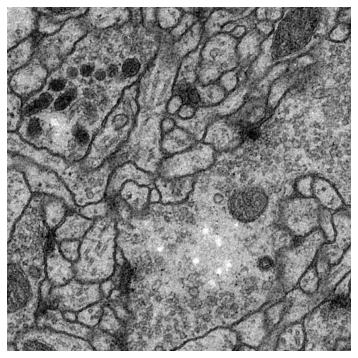

In [54]:
import cv2
fig = plt.figure(figsize=(10, 7))
num = np.random.randint(0,7)

fig.add_subplot(1,2, 1)
img = cv2.imread('/content/data/test/'+str(num)+'.png')
plt.imshow(img/255, cmap = "gray")
plt.axis("off")
plt.tight_layout()

#UNet

We have defined below a single UNet block

In [115]:
def UNetBlock(size = 64, ReductionMethod = "MaxPooling", inputs = None, pool_size = (2,2), activation = 'relu', DropOut = False, DropOutRate = 0.5):
      
      conv = Conv2D(size, 3, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(inputs)
      conv = Conv2D(size, 3, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(conv)
      drp = None
      pool = None
      if DropOut == True:
          conv = Dropout(DropOutRate)(conv)
          drp = conv

      if ReductionMethod == "MaxPooling":
          pool = MaxPooling2D(pool_size = pool_size)(conv)

      return drp, conv, pool

An Upsampling Component Function

In [116]:
def UpsamplingUnit(inputs = None, skip_conn_unit = None, size = 64):
     
      up_input = UpSampling2D(size = (2,2))(inputs)
      conv = Conv2D(size, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up_input)
      skip_conn = concatenate([ skip_conn_unit, conv], axis = 3)
      return skip_conn

Defining The whole Architecture 

In [117]:
def UNet(input_size = (256,256,1)):
    
    # We obtain inputs in the form of 256x256 images
    inputs = Input(input_size)

    # The first first level Conv layer 
    _, conv1_block, pool1 = UNetBlock(64, "MaxPooling", inputs, (2,2), 'relu')

    # The first second level Conv layer 
    _, conv2_block, pool2 = UNetBlock(128, "MaxPooling", pool1, (2,2), 'relu')
    
    # The first third level Conv layer
    _, conv3_block, pool3 = UNetBlock(256, "MaxPooling", pool2, (2,2), 'relu')

    # The first fourtth level Conv layer 
    drp4, conv4_block, pool4 = UNetBlock(512, "MaxPooling", pool3, (2,2), 'relu', True, 0.5)

    # The fifth level Conv layer 
    drp5, conv5_block, pool5 = UNetBlock(1024, "None", pool4, (2,2), 'relu', True, 0.5)

    # The second fourth level Conv layer 
    conv6_upsample = UpsamplingUnit(drp5, drp4, 512)
    _, conv6_block, _ = UNetBlock(512, "None", conv6_upsample)    
   
    # The second third level Conv layer 
    conv7_upsample = UpsamplingUnit(conv6_block, conv3_block, 256)
    _, conv7_block, _ = UNetBlock(256, "None", conv7_upsample)    
    
    # The second second level Conv layer 
    conv8_upsample = UpsamplingUnit(conv7_block, conv2_block, 128)
    _, conv8_block, _ = UNetBlock(128, "None", conv8_upsample)    

    # The second first level Conv layer 
    conv9_upsample = UpsamplingUnit(conv8_block, conv1_block, 64)
    _, conv9_block, _ = UNetBlock(64, "None", conv9_upsample)    

    # Sigmoid Activation to get a binary segmentation probabilty after a ReLu activation
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9_block)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)
    model.summary()
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

#Component Functions

# 1. Training Generator. Here we add code for data augmentation since the data is a scarce. 

In [118]:
def TrGen(batch_size, train_path, image_folder, mask_folder, save_to_dir = None, target_size = (256,256), seed = 1):
    data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
  
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = "grayscale",
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = "image",
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = "grayscale",
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = "mask",
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        yield (img,mask)

# 2. Testing Generator. 

In [119]:
def TeGen(test_path,num_image = 30,target_size = (256,256),as_gray = True):
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,"%d.png"%i),as_gray = as_gray)
        img = img / 255
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,))
        img = np.reshape(img,(1,)+img.shape)
        yield img

3. Saving Result

In [120]:
def SaveRes(save_path,npyfile):
    for i,item in enumerate(npyfile):
        img = item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

#Training

In [122]:
myGene = TrGen(2, 'content/data/train', 'image', 'label', save_to_dir = None)

model = UNet()
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=300,epochs=5,callbacks=[model_checkpoint])

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_386 (Conv2D)            (None, 256, 256, 64  640         ['input_20[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_387 (Conv2D)            (None, 256, 256, 64  36928       ['conv2d_386[0][0]']             
                                )                                                          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/5
300/300 [==============================] - ETA: 0s - loss: 0.3288 - accuracy: 0.8545
Epoch 1: loss improved from inf to 0.32875, saving model to unet_membrane.hdf5
300/300 [==============================] - 162s 534ms/step - loss: 0.3288 - accuracy: 0.8545
Epoch 2/5
300/300 [==============================] - ETA: 0s - loss: 0.2742 - accuracy: 0.9013
Epoch 2: loss improved from 0.32875 to 0.27424, saving model to unet_membrane.hdf5
300/300 [==============================] - 160s 533ms/step - loss: 0.2742 - accuracy: 0.9013
Epoch 3/5
300/300 [==============================] - ETA: 0s - loss: 0.2104 - accuracy: 0.9137
Epoch 3: loss improved from 0.27424 to 0.21040, saving model to unet_membrane.hdf5
300/300 [==============================] - 160s 534ms/step - loss: 0.2104 - accuracy: 0.9137
Epoch 4/5
300/300 [==============================] - ETA: 0s - loss: 0.1790 - accuracy: 0.9217
Epoch 4: loss improved from 0.21040 to 0.17903, saving model to unet_membrane.hdf5
300/300 [====

#Testing

In [127]:
testGene = TeGen("/content/data/test")
model = UNet()
model.load_weights("unet.hdf5")
results = model.predict_generator(testGene,30,verbose=1)
SaveRes("data/results",results)

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_458 (Conv2D)            (None, 256, 256, 64  640         ['input_23[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_459 (Conv2D)            (None, 256, 256, 64  36928       ['conv2d_458[0][0]']             
                                )                                                          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


30/30 [==============================] - 4s 122ms/step
